In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from sklearn.preprocessing import LabelBinarizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import SGD, Adam, Adadelta
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

import utils  ## .py

### Load meta data

In [2]:
# Directory where mp3 are stored.  ### in terminal write: export AUDIO_DIR=./'directory where the mp3 are stored'
AUDIO_DIR=os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks_ = utils.load('fma/data/fma_metadata/tracks.csv')
genres = utils.load('fma/data/fma_metadata/genres.csv')
features = utils.load('fma/data/fma_metadata/features.csv')
echonest = utils.load('fma/data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks_.index)
assert echonest.index.isin(tracks_.index).all()

tracks_.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

### Parameters


In [3]:
## Possible trainings
model_dim = 'both' ## '1d' or '2d' 'both'
Division = True ## if data gets diveded in small pieces
Drop_out = False

N = 7994 ## number of data samples we will work with (max = 7994)
batch_size = 50
epochs = 15
lr = 5e-4

model_saving_name = 'model.pt'

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = 'cpu'
print(device)

cuda


In [4]:
max_len = 1_000_000  ## max = 1_321_438
n_fft = 2048  ## for the STFT fourier transform
n_rows = int(np.round((n_fft+1.1)/2))
hop_length = n_fft//2  ## n_fft/a  1/a = overlap
n_columns = int(np.ceil(max_len/hop_length))
if Division == True:
    num_divisions = 7
    stride_calc = 919 
 #int(max_len/(N+19))-200

elif Division == False:
    num_divisions = 1
    stride_calc = 1007

if Drop_out == True:
    drop_out = 0.2
elif Drop_out == False:
    drop_out = 0


n_columns_division = int(n_columns/num_divisions)
n_data_division = int(max_len/num_divisions)

print(f'Shape of data 1D: (1,{n_data_division})')
print(f'Sape of data 2D: {n_rows,n_columns_division}')

Shape of data 1D: (1,142857)
Sape of data 2D: (1025, 139)


### Data "preprocessing"


In [5]:
## SUBSETING , we are only going to work with the small data_set and oly with N samples.

subset = tracks_.index[tracks_['set', 'subset'] <= 'small'].drop([98565,98567,98569,99134,108925,133297])
tracks = tracks_.loc[subset].iloc[:N]

## taking the different indexes for train, validation and testing
train = tracks.index[tracks['set', 'split'] == 'training'].values
val = tracks.index[tracks['set', 'split'] == 'validation'].values
test = tracks.index[tracks['set', 'split'] == 'test'].values

In [6]:
# getting the "Y" vectors (classification of the data) as onehot encoded
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)
number_genre = labels_onehot.shape[1]


### Datasets

In [7]:
class STFTLoader(utils.Loader):
    raw_loader = utils.LibrosaLoader()

    def load(self, filename):
        import librosa
        x = self.raw_loader.load(filename)
        x_short = x[:max_len] ## getting only up to a certain length of the data sample (to have the same length for all data)
        
        stft = np.abs(librosa.stft(x_short, n_fft=n_fft, hop_length=hop_length))  ## n_fft is the size of the FFT,, hop_length is frame increment between 
        ## two consecutive FFT
        return stft ,x# return a matrix (q,p) where p is the number of columns of the matrix (important afterwards)

In [8]:
loader_1d = utils.LibrosaLoader(sampling_rate=44100) ## 1d loader for raw audio
loader_2d = STFTLoader()  # 2d loader for stft matrix
loader_2d.load('fma/data/fma_small/000/000002.mp3')[1].shape  ##example for 2D data shape


(1321967,)

In [9]:
class Dataset_1d(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, tids, onehot): ## tids = train, val or test. Are the indixes
        'Initialization'
        self.labels = onehot
        self.tids = tids
        self.loader = loader_1d
        self.audio_path = utils.get_audio_path
        self.audio_dir = AUDIO_DIR
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.tids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        y = self.labels.loc[self.tids[index]]
        audio_name = self.audio_path(self.audio_dir, self.tids[index])
        x = self.loader.load(audio_name)[:max_len]
        
        X_ = torch.from_numpy(np.array(x,dtype='float32'))
        X = X_.reshape( *X_.shape,1)
        Y = torch.from_numpy(np.array(y,dtype='float32'))

        return X, Y

In [10]:
class Dataset_2d(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, tids, onehot): ## tids = train, val or test. Are the indixes
        'Initialization'
        self.labels = onehot
        self.tids = tids
        self.loader = loader_2d
        self.audio_path = utils.get_audio_path
        self.audio_dir = AUDIO_DIR
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.tids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        y = self.labels.loc[self.tids[index]]
        audio_name = self.audio_path(self.audio_dir, self.tids[index])
        x = self.loader.load(audio_name)[0]
        
        X = torch.from_numpy(np.array(x,dtype='float32')).permute(1,0)
        Y = torch.from_numpy(np.array(y,dtype='float32'))

        return X, Y

In [11]:
class Dataset_both(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, tids, onehot): ## tids = train, val or test. Are the indixes
        'Initialization'
        self.labels = onehot
        self.tids = tids
        self.loader = loader_2d
        self.audio_path = utils.get_audio_path
        self.audio_dir = AUDIO_DIR
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.tids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        y = self.labels.loc[self.tids[index]]
        audio_name = self.audio_path(self.audio_dir, self.tids[index])
        x_2, x_1  = self.loader.load(audio_name)
        
        X_1_ = torch.from_numpy(np.array(x_1,dtype='float32'))
        X_2 = torch.from_numpy(np.array(x_2,dtype='float32')).permute(1,0)
        X_1 = X_1_.reshape(*X_1_.shape ,1)[:max_len]
        
        Y = torch.from_numpy(np.array(y,dtype='float32'))

        return X_1, X_2, Y

### Networks

#### 1d

In [12]:
class Network1d(nn.Module):
    
    def __init__(self, batch_size, n_columns, kernel_size): ## kernell size has to be [a, n_rows] 
        super().__init__()
        self.conv_path_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=256, kernel_size = [stride_calc*20, 1], stride = [stride_calc, 1], padding=[0, 0]), 
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.conv_path_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[4,1],padding=[2,0]), ##padding so it matches de dimension of conv_path 1
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[4,1],padding=[1,0]), ##padding so it matches de dimension of conv_path 1
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.flatten = nn.Flatten(start_dim=1)

        self.maxpool = nn.MaxPool2d(kernel_size=[n_columns-kernel_size[0]+1,1]) ## -(kernel_size[0]-1) since is the dim of conv path 1
        self.avgpool = nn.AvgPool2d(kernel_size=[n_columns-kernel_size[0]+1,1])
        
        self.linear_path = nn.Sequential(
            nn.Linear(in_features=256*2, out_features=300), ## in is n_fft*2 (2 different poolings)
            nn.BatchNorm1d(300),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Linear(in_features=300, out_features=150),
            nn.BatchNorm1d(150),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Linear(in_features=150, out_features=number_genre), ## out number of genres
            nn.BatchNorm1d(number_genre),
            nn.ELU()
        )
               
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        
        x1_1 = self.conv_path_1(x)
        x1_2 = self.conv_path_2(x1_1)
        x2 = x1_1 + x1_2
        x3 = torch.cat((self.maxpool(x2),self.avgpool(x2)),2)
        x4 = self.linear_path(self.flatten(x3))

        
        return x4



#### 2d

In [13]:
class Network2d(nn.Module):
    
    def __init__(self, batch_size, n_columns, kernel_size): ## kernell size has to be [a, n_rows] 
        super().__init__()
        self.conv_path_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=256, kernel_size=kernel_size,padding=[0,0]), ## does a convolution over the width so yileds a 1d vector
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.conv_path_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[4,1],padding=[2,0]), ##padding so it matches de dimension of conv_path 1
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[4,1],padding=[1,0]), ##padding so it matches de dimension of conv_path 1
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.flatten = nn.Flatten(start_dim=1)

        self.maxpool = nn.MaxPool2d(kernel_size=[n_columns-kernel_size[0]+1,1]) ## -(kernel_size[0]-1) since is the dim of conv path 1
        self.avgpool = nn.AvgPool2d(kernel_size=[n_columns-kernel_size[0]+1,1])
        
        self.linear_path = nn.Sequential(
            nn.Linear(in_features=256*2, out_features=300), ## in is n_fft*2 (2 different poolings)
            nn.BatchNorm1d(300),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Linear(in_features=300, out_features=150),
            nn.BatchNorm1d(150),
            nn.ELU(),
            nn.Linear(in_features=150, out_features=number_genre), ## out number of genres
            nn.BatchNorm1d(number_genre),
            nn.ELU()
        )
               
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        
        x1_1 = self.conv_path_1(x)
        x1_2 = self.conv_path_2(x1_1)
        x2 = x1_1 + x1_2
        x3 = torch.cat((self.maxpool(x2),self.avgpool(x2)),2)
        x4 = self.linear_path(self.flatten(x3))

        
        return x4



#### Both

In [14]:
class NetworkBoth(nn.Module):
    
    def __init__(self, batch_size, n_columns, kernel_size): ## kernell size has to be [a, n_rows] 
        super().__init__()
        self.conv_path_1_2d = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=128, kernel_size=kernel_size,padding=[0,0]), ## does a convolution over the width so yileds a 1d vector
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.conv_path_1_1d = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=128, kernel_size = [stride_calc*20, 1], stride = [stride_calc, 1], padding=[0, 0]), ## convolution over the 1d input to match sizes
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.conv_path_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[4,1],padding=[2,0]), ##padding so it matches de dimension of conv_path 1
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[4,1],padding=[1,0]), ##padding so it matches de dimension of conv_path 1
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(drop_out)
        )
        self.flatten = nn.Flatten(start_dim=1)

        self.maxpool = nn.MaxPool2d(kernel_size=[n_columns-kernel_size[0]+1,1]) ## -(kernel_size[0]-1) since is the dim of conv path 1
        self.avgpool = nn.AvgPool2d(kernel_size=[n_columns-kernel_size[0]+1,1])
        
        self.linear_path = nn.Sequential(
            nn.Linear(in_features=256*2, out_features=300), ## in is n_fft*2 (2 different poolings)
            nn.BatchNorm1d(300),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Linear(in_features=300, out_features=150),
            nn.BatchNorm1d(150),
            nn.ELU(),
            nn.Dropout(drop_out),
            nn.Linear(in_features=150, out_features=number_genre), ## out number of genres
            nn.BatchNorm1d(number_genre),
            nn.ELU()
        )
               
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x_1d, x_2d):
        
        x1_1d = self.conv_path_1_1d(x_1d)
        x1_2d = self.conv_path_1_2d(x_2d)
        x1_together = torch.cat((x1_1d, x1_2d), 1)
        
        x2 = self.conv_path_2(x1_together)
        x3 = x1_together + x2
        x4 = torch.cat((self.maxpool(x3),self.avgpool(x3)),2)
        x5 = self.linear_path(self.flatten(x4))
        
        return x5



### Training

#### 1d

In [15]:
### Training for model 1d

if model_dim == '1d':
    model = Network1d(batch_size, n_columns=n_columns_division, kernel_size=[4,n_rows])
                                                                                
    train_data = Dataset_1d(train, labels_onehot)
    valid_data = Dataset_1d(val, labels_onehot)
    
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size)

    opt = Adam(model.parameters(), lr = lr)
    loss_fn = CrossEntropyLoss()
    
    
    
    model.to(device)
    
    best_val = np.inf
    
    loss_train = np.array([])
    loss_train_epoch = []
    loss_val_epoch = []
    
    for epoch in range(epochs):
        loss_avg = 0
        loss_avg_val = 0
        n_loss = 0
        n_loss_val = 0
        
        model.train()
        print(f"Epoch: {epoch+1}")
        iterator = tqdm(train_loader)
        for batch_x, batch_y in (iterator):
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
    
            batch_x = batch_x.reshape(1, *batch_x.shape).permute(1,0,2,3)
            
            y_pred = 0
            for j in range(max([num_divisions*2-3,1])):
                batch_x_j = batch_x[:,:,int(n_data_division*j/2):int(n_data_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                
                y_pred_j = model(batch_x_j) 
                loss = loss_fn(y_pred_j,batch_y) ## the loss is computed and the gradient is computed inside the for loop, for each segment
                n_loss = n_loss+1

                loss_avg = loss_avg + loss.detach().cpu().numpy()
                
                opt.zero_grad()
                loss.backward()
                opt.step()
                iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    
            

        model.eval()
        with torch.no_grad():

            predictions = []
            true = []
            for batch_x, batch_y in tqdm(valid_loader):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
    
                batch_x = batch_x.reshape(1, *batch_x.shape).permute(1,0,2,3)
                
    
                y_pred = 0
                for j in range(max([num_divisions*2-3,1])):
                    
                    batch_x_j = batch_x[:,:,int(n_data_division*j/2):int(n_data_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                    
                    y_pred_j = model(batch_x_j)
                    
                    loss_avg_val = loss_avg_val + loss_fn(y_pred_j, batch_y).detach().cpu().numpy() ## this loss (inside) is to compare with training loss, is computed for each segment
                    n_loss_val = n_loss_val + 1
                    
                    y_pred = y_pred + y_pred_j/max([num_divisions*2-3,1])
                
                predictions.append(y_pred) 
                true.append(batch_y)
            predictions = torch.cat(predictions, axis=0)
            true = torch.cat(true, axis=0)   ## the loss is computed OUTSIDE the for loop, once the predictions for the whole song is computed
                                            ## this is the loss that we use to decide to save the model or not.
            val_loss = loss_fn(predictions, true)
    
            index = torch.argmax(predictions,axis=1).detach().cpu().numpy()
            zeros = np.zeros(predictions.shape)
            zeros[np.arange(index.shape[0]), index]=1
            
            val_acc = np.sum(np.equal(np.sum(np.equal(zeros,true.detach().cpu().numpy()).astype(int),axis=1),number_genre).astype(int))/predictions.shape[0]
                
            print(f"loss: {val_loss}, accuracy: {val_acc}")
        loss_val_epoch.append(loss_avg_val/n_loss_val)
        loss_train_epoch.append(loss_avg/n_loss)
        
        if val_loss < best_val:
            print("Saved Model")
            torch.save(model.state_dict(), model_saving_name)
            best_val = val_loss
    
    plt.plot(np.arange(1,epoch+2),loss_train_epoch,label='Training Loss')
    plt.plot(np.arange(1,epoch+2),loss_val_epoch,label='Validation Loss ("segment-wise")')
    plt.legend()

else:
    None

#### 2d

In [16]:
### Training for model 2d

if model_dim == '2d':
    model = Network2d(batch_size, n_columns=n_columns_division, kernel_size=[4,n_rows])
    
    train_data = Dataset_2d(train, labels_onehot)
    valid_data = Dataset_2d(val, labels_onehot)
    
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size)

    opt = Adam(model.parameters(), lr=lr)
    loss_fn = CrossEntropyLoss()
    
    
    
    model.to(device)
    
    best_val = np.inf
    
    loss_train = np.array([])
    loss_train_epoch = []
    loss_val_epoch = []
    
    for epoch in range(epochs):      
        loss_avg = 0
        loss_avg_val = 0
        n_loss = 0
        n_loss_val = 0
        
        model.train()
        print(f"Epoch: {epoch+1}")
        iterator = tqdm(train_loader)
        for batch_x, batch_y in (iterator):
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            batch_x = batch_x.reshape(1, *batch_x.shape).permute(1,0,2,3)
            
            y_pred = 0
            for j in range(max([num_divisions*2-3,1])):
                batch_x_j = batch_x[:,:,int(n_columns_division*j/2):int(n_columns_division*(j+2)/2),:]  ## 50% of overlap between pieces of data

                y_pred_j = model(batch_x_j)
                loss = loss_fn(y_pred_j,batch_y)

                n_loss = n_loss+1
                loss_avg = loss_avg + loss.detach().cpu().numpy()
    
                opt.zero_grad()
                loss.backward()
                opt.step()
                iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
                

        model.eval()
        with torch.no_grad():

            predictions = []
            true = []
            for batch_x, batch_y in tqdm(valid_loader):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
    
                batch_x = batch_x.reshape(1, *batch_x.shape).permute(1,0,2,3)
                
    
                y_pred = 0
                for j in range(max([num_divisions*2-3,1])):
                    
                    batch_x_j = batch_x[:,:,int(n_columns_division*j/2):int(n_columns_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                    
                    y_pred_j = model(batch_x_j)
                    y_pred = y_pred + y_pred_j/max([num_divisions*2-3,1])
                    
                    loss_avg_val = loss_avg_val + loss_fn(y_pred_j, batch_y).detach().cpu().numpy()
                    n_loss_val = n_loss_val + 1
                
                predictions.append(y_pred)
                true.append(batch_y)
            predictions = torch.cat(predictions, axis=0)
            true = torch.cat(true, axis=0)
            val_loss = loss_fn(predictions, true)
    
            index = torch.argmax(predictions,axis=1).detach().cpu().numpy()
            zeros = np.zeros(predictions.shape)
            zeros[np.arange(index.shape[0]), index]=1
            
            val_acc = np.sum(np.equal(np.sum(np.equal(zeros,true.detach().cpu().numpy()).astype(int),axis=1),number_genre).astype(int))/predictions.shape[0]
                
            print(f"loss: {val_loss}, accuracy: {val_acc}")
        loss_val_epoch.append(loss_avg_val/n_loss_val)
        loss_train_epoch.append(loss_avg/n_loss)
        
        if val_loss < best_val:
            print("Saved Model")
            torch.save(model.state_dict(), model_saving_name)
            best_val = val_loss
    plt.plot(np.arange(1,epoch+2),loss_train_epoch,label='Training Loss')
    plt.plot(np.arange(1,epoch+2),loss_val_epoch,label='Validation Loss ("segment-wise")')
    plt.legend()


else:
    None

#### Both

Epoch: 1


Train loss: 1.2963497638702393:  66%|████████████████████████████████▊                 | 84/128 [21:15<13:25, 18.30s/it][src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (3328) too large for available bit count (3240)
100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:16<00:00,  8.56s/it]


loss: 1.5180672407150269, accuracy: 0.46875
Saved Model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:06<00:00,  7.90s/it]


loss: 1.5542808771133423, accuracy: 0.4525
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:57<00:00,  7.34s/it]


loss: 1.5127630233764648, accuracy: 0.46875
Saved Model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:52<00:00,  7.03s/it]


loss: 1.4462952613830566, accuracy: 0.52125
Saved Model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [03:32<00:00, 13.31s/it]


loss: 1.4674230813980103, accuracy: 0.49875
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:19<00:00,  8.73s/it]


loss: 1.4630428552627563, accuracy: 0.5
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:12<00:00,  8.30s/it]


loss: 1.556207299232483, accuracy: 0.51375
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:10<00:00,  8.13s/it]


loss: 1.5870018005371094, accuracy: 0.505
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:10<00:00,  8.14s/it]


loss: 1.651961326599121, accuracy: 0.50125
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:19<00:00,  8.70s/it]


loss: 1.5868428945541382, accuracy: 0.4825
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:04<00:00,  7.76s/it]


loss: 1.6569173336029053, accuracy: 0.5
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:05<00:00,  7.85s/it]


loss: 1.702966570854187, accuracy: 0.43875
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:12<00:00,  8.29s/it]


loss: 1.9353164434432983, accuracy: 0.4575
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:11<00:00,  8.22s/it]


loss: 1.79318368434906, accuracy: 0.47375
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:22<00:00,  8.89s/it]


loss: 1.9234191179275513, accuracy: 0.455


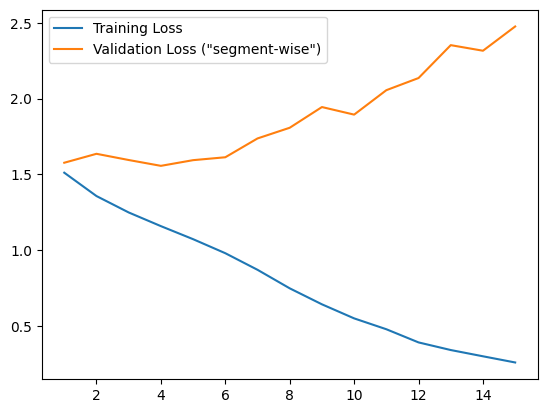

In [17]:
if model_dim == 'both':
    model = NetworkBoth(batch_size, n_columns=n_columns_division, kernel_size=[4,n_rows])
                
    train_data = Dataset_both(train, labels_onehot)
    valid_data = Dataset_both(val, labels_onehot)
    
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size)

    opt = Adam(model.parameters(),lr=lr)
    loss_fn = nn.CrossEntropyLoss()
  
    model.to(device)
    
    best_val = np.inf
    
    loss_train = np.array([])
    loss_train_epoch = []
    loss_val_epoch = []
    
    for epoch in range(epochs):
        loss_avg = 0
        loss_avg_val = 0
        n_loss = 0
        n_loss_val = 0
        model.train()
        print(f"Epoch: {epoch+1}")
        iterator = tqdm(train_loader)
        for batch_x1, batch_x2, batch_y in (iterator):
            
            batch_x1 = batch_x1.to(device)
            batch_x2 = batch_x2.to(device)
            batch_y = batch_y.to(device)
    
            batch_x1 = batch_x1.reshape(1, *batch_x1.shape).permute(1,0,2,3)
            batch_x2 = batch_x2.reshape(1, *batch_x2.shape).permute(1,0,2,3)
            
            y_pred = 0
                
            for j in range(max([num_divisions*2-3,1])):
                batch_x_j1 = batch_x1[:,:,int(n_data_division*j/2):int(n_data_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                batch_x_j2 = batch_x2[:,:,int(n_columns_division*j/2):int(n_columns_division*(j+2)/2),:]
                
                y_pred_j = model(batch_x_j1, batch_x_j2)
        
                loss = loss_fn(y_pred_j,batch_y)

                n_loss = n_loss+1
                loss_avg = loss_avg + loss.detach().cpu().numpy()
        
                opt.zero_grad()
                loss.backward()
                opt.step()
                iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
                
    
        model.eval()
        with torch.no_grad():
            predictions = []
            true = []
            for batch_x1, batch_x2, batch_y in (tqdm(valid_loader)):
                
                batch_x1 = batch_x1.to(device)
                batch_x2 = batch_x2.to(device)
                batch_y = batch_y.to(device)
                
            
                batch_x1 = batch_x1.reshape(1, *batch_x1.shape).permute(1,0,2,3)
                batch_x2 = batch_x2.reshape(1, *batch_x2.shape).permute(1,0,2,3)
                
                y_pred = 0
                
                for j in range(max([num_divisions*2-3,1])):
                    batch_x_j1 = batch_x1[:,:,int(n_data_division*j/2):int(n_data_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                    batch_x_j2 = batch_x2[:,:,int(n_columns_division*j/2):int(n_columns_division*(j+2)/2),:]
                    
                    y_pred_j = model(batch_x_j1, batch_x_j2)
                    y_pred = y_pred + y_pred_j/max([num_divisions*2-3,1])

                    loss_avg_val = loss_avg_val + loss_fn(y_pred_j, batch_y).detach().cpu().numpy()
                    n_loss_val = n_loss_val + 1
    
                predictions.append(y_pred)
                true.append(batch_y)
                    
            predictions = torch.cat(predictions, axis=0)
            true = torch.cat(true, axis=0)
            val_loss = loss_fn(predictions,true)
    
            index = torch.argmax(predictions,axis=1).detach().cpu().numpy()
            zeros = np.zeros(predictions.shape)
            zeros[np.arange(index.shape[0]), index]=1
            
            val_acc = np.sum(np.equal(np.sum(np.equal(zeros,true.detach().cpu().numpy()).astype(int),axis=1),number_genre).astype(int))/predictions.shape[0]
                
            print(f"loss: {val_loss}, accuracy: {val_acc}")

        loss_val_epoch.append(loss_avg_val/n_loss_val)
        loss_train_epoch.append(loss_avg/n_loss)
        
        if val_loss < best_val:
            print("Saved Model")
            torch.save(model.state_dict(), model_saving_name)
            best_val = val_loss
    plt.plot(np.arange(1,epoch+2),loss_train_epoch,label='Training Loss')
    plt.plot(np.arange(1,epoch+2),loss_val_epoch,label='Validation Loss ("segment-wise")')
    plt.legend()

else:
    None

### TEST

In [18]:
model_name = 'model.pt' #Name of the model we want to test

#### 1d

In [19]:
if model_dim == '1d':
    model = Network1d(batch_size, n_columns=n_columns_division, kernel_size=[4,n_rows])
                                                                                 
    test_data = Dataset_1d(test, labels_onehot)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)
    
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    
    loss_fn = CrossEntropyLoss()
    
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(test_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_x = batch_x.reshape(1, *batch_x.shape).permute(1,0,2,3)
            

            y_pred = 0
            for j in range(max([num_divisions*2-3,1])):
                
                batch_x_j = batch_x[:,:,int(n_data_division*j/2):int(n_data_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                
                y_pred_j = model(batch_x_j)
                y_pred = y_pred + y_pred_j/max([num_divisions*2-3,1])
            
            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)

        index = torch.argmax(predictions,axis=1).detach().cpu().numpy()
        zeros = np.zeros(predictions.shape)
        zeros[np.arange(index.shape[0]), index]=1
        
        val_acc = np.sum(np.equal(np.sum(np.equal(zeros,true.detach().cpu().numpy()).astype(int),axis=1),number_genre).astype(int))/predictions.shape[0]
            
        print(f"loss: {val_loss}, accuracy: {val_acc}")

#### 2d

In [20]:
if model_dim == '2d':
    model = Network2d(batch_size, n_columns=n_columns_division, kernel_size=[4,n_rows])
                                                                                 
    test_data = Dataset_2d(test, labels_onehot)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)
    
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    
    loss_fn = CrossEntropyLoss()
    
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(test_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_x = batch_x.reshape(1, *batch_x.shape).permute(1,0,2,3)
            

            y_pred = 0
            for j in range(max([num_divisions*2-3,1])):
                
                batch_x_j = batch_x[:,:,int(n_columns_division*j/2):int(n_columns_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                
                y_pred_j = model(batch_x_j)
                y_pred = y_pred + y_pred_j/max([num_divisions*2-3,1])
            
            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)

        index = torch.argmax(predictions,axis=1).detach().cpu().numpy()
        zeros = np.zeros(predictions.shape)
        zeros[np.arange(index.shape[0]), index]=1
        
        val_acc = np.sum(np.equal(np.sum(np.equal(zeros,true.detach().cpu().numpy()).astype(int),axis=1),number_genre).astype(int))/predictions.shape[0]
            
        print(f"loss: {val_loss}, accuracy: {val_acc}")

#### Both

In [21]:
if model_dim == 'both':
    model = NetworkBoth(batch_size, n_columns=n_columns_division, kernel_size=[4,n_rows])
                                                                                 
    test_data = Dataset_both(test, labels_onehot)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)
    
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    
    loss_fn = CrossEntropyLoss()
    
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x1, batch_x2, batch_y in (tqdm(test_loader)):
            
            batch_x1 = batch_x1.to(device)
            batch_x2 = batch_x2.to(device)
            batch_y = batch_y.to(device)
        
            batch_x1 = batch_x1.reshape(1, *batch_x1.shape).permute(1,0,2,3)
            batch_x2 = batch_x2.reshape(1, *batch_x2.shape).permute(1,0,2,3)
            
            y_pred = 0
            
            for j in range(num_divisions*2-3):
                batch_x_j1 = batch_x1[:,:,int(n_data_division*j/2):int(n_data_division*(j+2)/2),:]  ## 50% of overlap between pieces of data
                batch_x_j2 = batch_x2[:,:,int(n_columns_division*j/2):int(n_columns_division*(j+2)/2),:]
                
                y_pred_j = model(batch_x_j1, batch_x_j2)
                y_pred = y_pred + y_pred_j/max([num_divisions*2-3,1])

            predictions.append(y_pred)
            true.append(batch_y)
                
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)

        index = torch.argmax(predictions,axis=1).detach().cpu().numpy()
        zeros = np.zeros(predictions.shape)
        zeros[np.arange(index.shape[0]), index]=1
        
        val_acc = np.sum(np.equal(np.sum(np.equal(zeros,true.detach().cpu().numpy()).astype(int),axis=1),number_genre).astype(int))/predictions.shape[0]
            
        print(f"loss: {val_loss}, accuracy: {val_acc}")
else:
    None
    

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:55<00:00,  7.23s/it]


loss: 1.7352166175842285, accuracy: 0.41
